In [3]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [4]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


### Data types exploration

In [5]:
data_types = data.dtypes
data_types

Diabetes_012            int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object

# Data preprocessing and visualisation

### Dublicates. Missing Values and Outliers

In [6]:
#check data's integrity
data.duplicated()
int(data.duplicated().sum())


23899

This are a lot of duplicates but I assume that this happens verry quick, even if it is really a different patient, with such a huge amount of categorical 2 group variables. Because of this it would be bad to drop dublicates and keep respectively the first of them.

In [7]:
#check for missing values
data.isna().sum(axis=1)
data.isna().any(axis=1).any()

np.False_

<- no missing values

Features and Label

In [8]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

(253680, 21)

Compute correlation matrix

In [9]:
corr_matrix = X.corr().abs() #abs trat negative values same as positive
corr_matrix

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
HighBP,1.000000,0.298199,0.098508,0.213748,0.096991,0.129575,0.209361,0.125267,0.040555,0.061266,...,0.038425,0.017358,0.300530,0.056456,0.161212,0.223618,0.052207,0.344452,0.141358,0.171235
HighChol,0.298199,1.000000,0.085642,0.106722,0.091299,0.092620,0.180765,0.078046,0.040859,0.039874,...,0.042230,0.013310,0.208426,0.062069,0.121751,0.144672,0.031205,0.272318,0.070802,0.085459
CholCheck,0.098508,0.085642,1.000000,0.034495,0.009929,0.024158,0.044206,0.004190,0.023849,0.006121,...,0.117626,0.058255,0.046589,0.008366,0.031775,0.040585,0.022115,0.090321,0.001510,0.014259
BMI,0.213748,0.106722,0.034495,1.000000,0.013804,0.020153,0.052904,0.147294,0.087518,0.062275,...,0.018471,0.058206,0.239185,0.085310,0.121141,0.197078,0.042950,0.036618,0.103932,0.100069
Smoker,0.096991,0.091299,0.009929,0.013804,1.000000,0.061173,0.114441,0.087401,0.077666,0.030678,...,0.023251,0.048946,0.163143,0.092196,0.116460,0.122463,0.093662,0.120641,0.161955,0.123937
Stroke,0.129575,0.092620,0.024158,0.020153,0.061173,1.000000,0.203002,0.069151,0.013389,0.041124,...,0.008776,0.034804,0.177942,0.070172,0.148944,0.176567,0.002978,0.126974,0.076009,0.128599
HeartDiseaseorAttack,0.209361,0.180765,0.044206,0.052904,0.114441,0.203002,1.000000,0.087299,0.019790,0.039167,...,0.018734,0.031000,0.258383,0.064621,0.181698,0.212709,0.086096,0.221618,0.099600,0.141011
PhysActivity,0.125267,0.078046,0.004190,0.147294,0.087401,0.069151,0.087299,1.000000,0.142756,0.153150,...,0.035505,0.061638,0.266186,0.125587,0.219230,0.253174,0.032482,0.092511,0.199658,0.198539
Fruits,0.040555,0.040859,0.023849,0.087518,0.077666,0.013389,0.019790,0.142756,1.000000,0.254342,...,0.031544,0.044243,0.103854,0.068217,0.044633,0.048352,0.091175,0.064547,0.110187,0.079929
Veggies,0.061266,0.039874,0.006121,0.062275,0.030678,0.041124,0.039167,0.153150,0.254342,1.000000,...,0.029584,0.032232,0.123066,0.058884,0.064290,0.080506,0.064765,0.009771,0.154329,0.151087


Plot correlation matrix

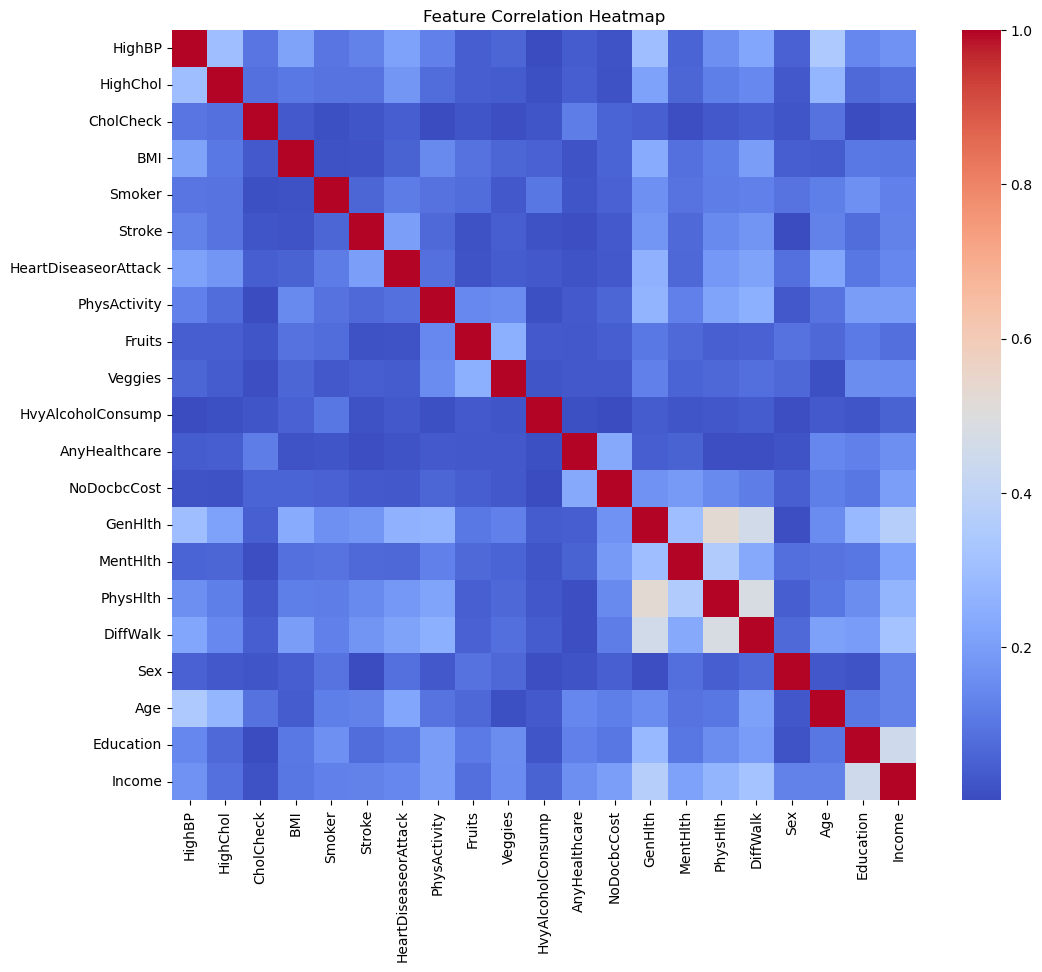

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

Remove higly correlated variables

In [11]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9 (threshold is adjustable)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop redundant features
X_reduced = X.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

Removed 0 highly correlated features: []


Use mutual information filter methods to quantify the amount of information that one variable provides about another

In [12]:
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

Let's try backword stepwise elimination (with multinominal logistische regression)

In [13]:
import statsmodels.api as sm

#Add constant for intercept
def multinomial(X): 
    X = sm.add_constant(X)
    cols = list(X.columns)
    pmax = 1

    while len(cols) > 0:
        # Inside your while loop:
        model = sm.MNLogit(y, X[cols]).fit(disp=0)

        # Take max p-value per feature across classes
        p_values = model.pvalues
        p_values_max = p_values.max(axis=1)
        pmax = p_values_max.max()
        feature_with_p_max = p_values_max.idxmax()

        # Backward elimination step
        if pmax > 0.05:
            print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
            cols.remove(feature_with_p_max)
        else:
            break

    print(f"Selected features: {cols}")
    return cols

multinomial(X)


Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']


['const',
 'HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'HvyAlcoholConsump',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'Sex',
 'Age',
 'Education',
 'Income']

LABEL, CATEGORICAL AND NUMERICAL FEATURES

**Numerical (Interval data** <- has no meaningful zero **) :** 
BMI

**Categorical (Ordinal data) :**
Diabetes_012, Age, GenHlth, MentHlth, PhyaHlth, Education, Income) 

**Categorical (Nominal data) :** Rest 
-> (HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex) 

In [14]:
label = ['Diabetes_012']
num_cols = ['BMI', 'Age']
cate_cols = data.columns.drop(['BMI', 'Age', 'Diabetes_012'])

### Data Visualisation

Distribution label Diabetes:

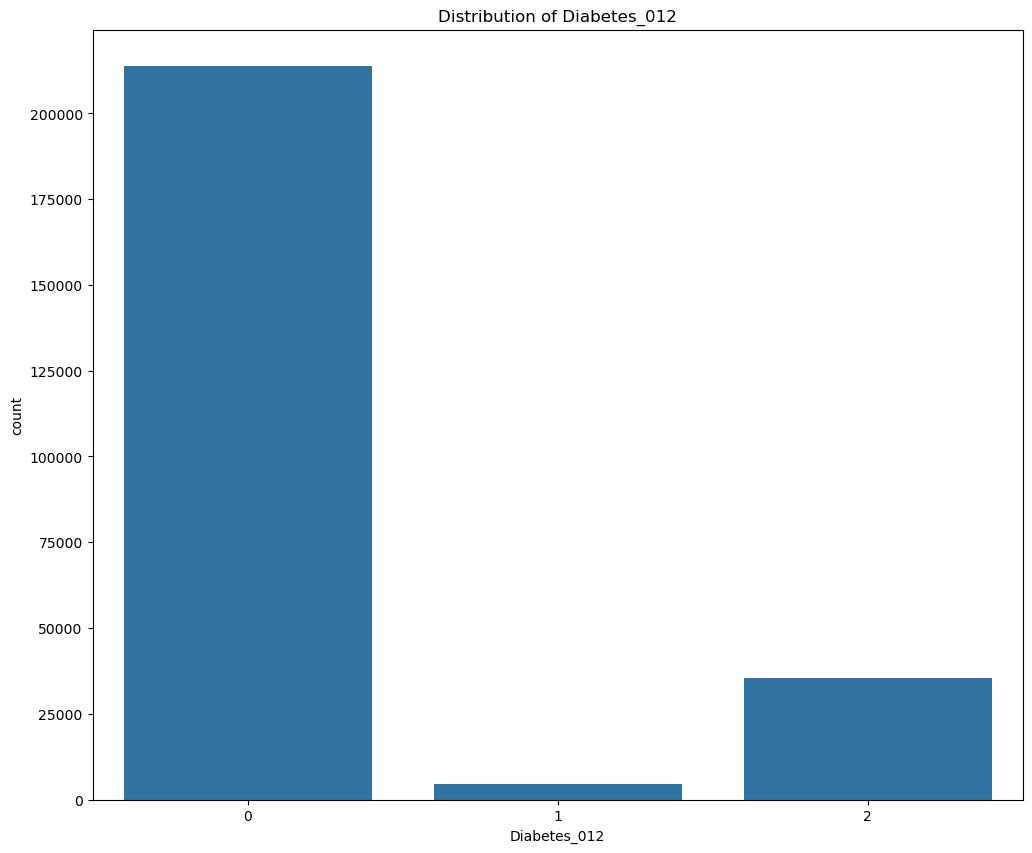

In [15]:
plt.figure(figsize=(12, 10))
sns.countplot(data=data, x='Diabetes_012')
plt.title('Distribution of Diabetes_012')
plt.show()

For the numerical features. See if there is a difference between Diabetes_012

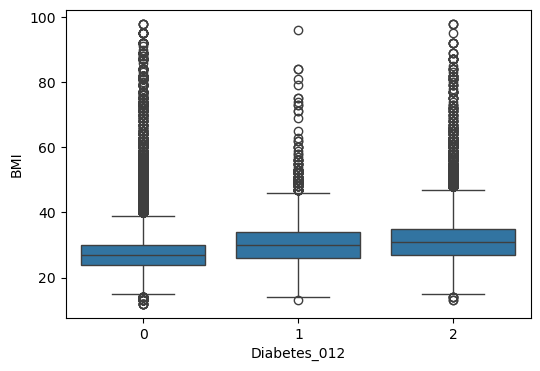

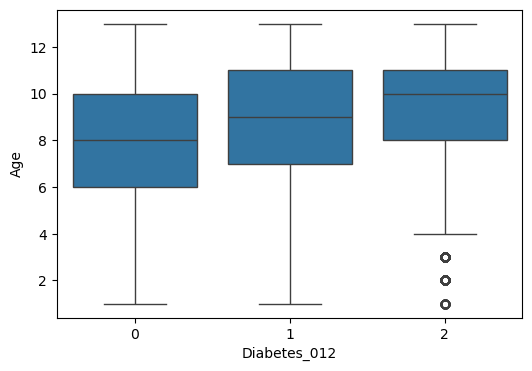

In [16]:
for i in range(len(num_cols)):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x='Diabetes_012', y=num_cols[i])
    plt.show()

Many outliers in BMI?

In [17]:
#Suggestion from Noemi:


➡ **Box Plot:** Use a box plot to show the data distribution and identify **outliers**. This type of chart works well when you have a lot of data and want to see the range and median of the data. A box-and-whisker plot displays the summary of a set of data:  the minimum, first quartile, median, third quartile, and maximum of the data subset. 

➡**Violin plots**: Use a box plot to visualize distribution and probability.  This hybrid chart works  version to shows the full distribution of the data and the peaks in the numeric dataset.  

➡ **Bar Chart:** Use a bar chart to compare categories or groups. This chart type works well when the data is discrete and not continuous.

Look at the distribution of every categorical variable

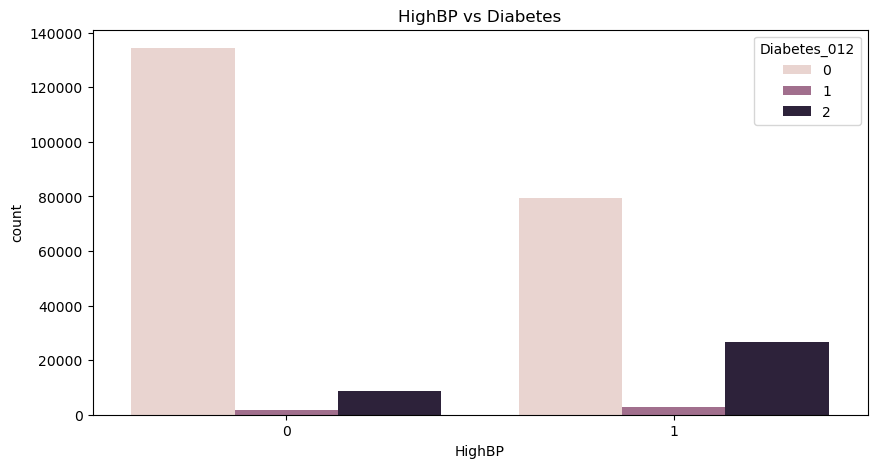

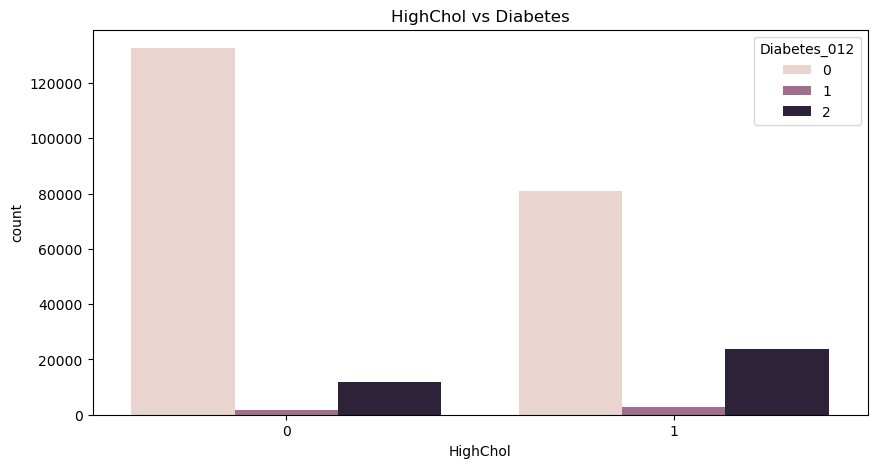

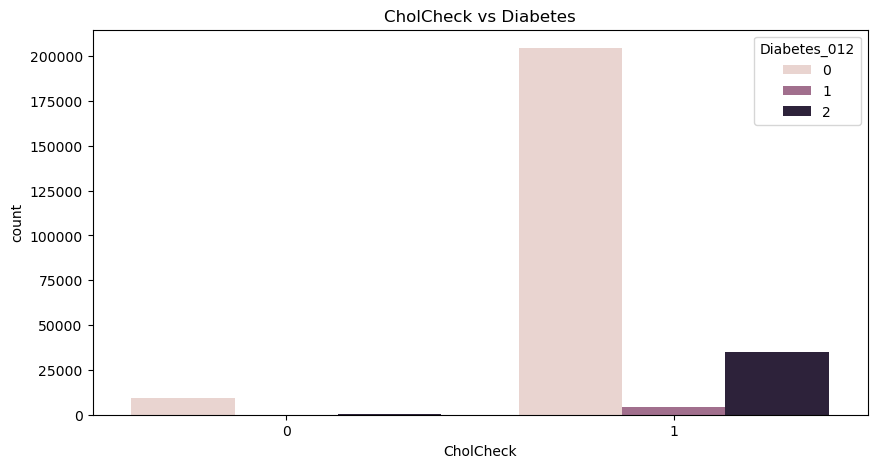

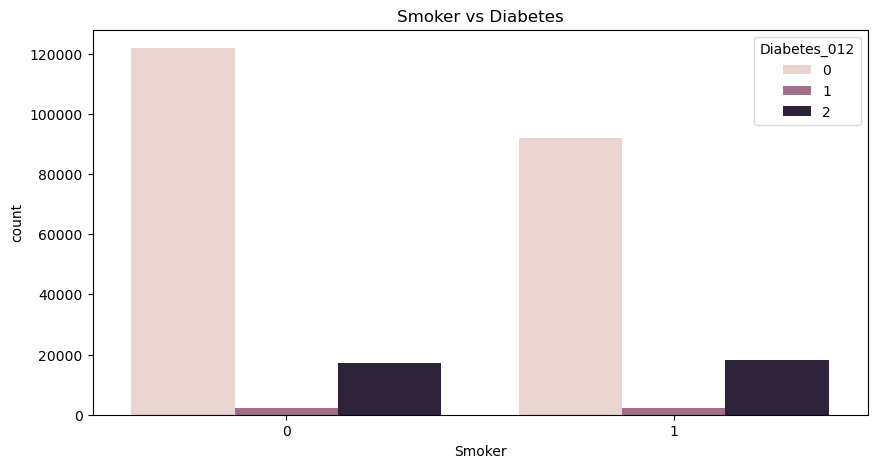

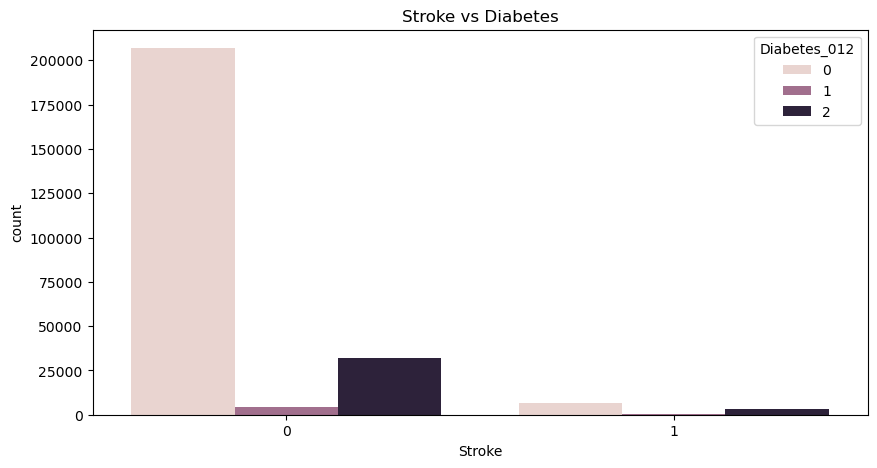

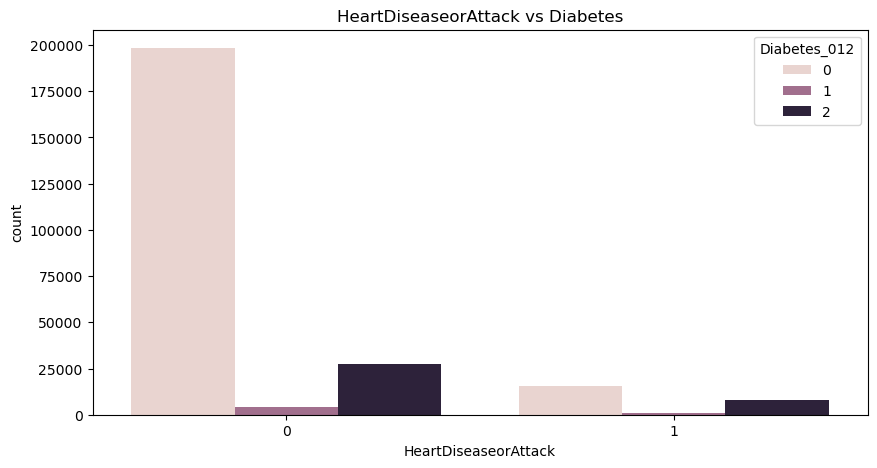

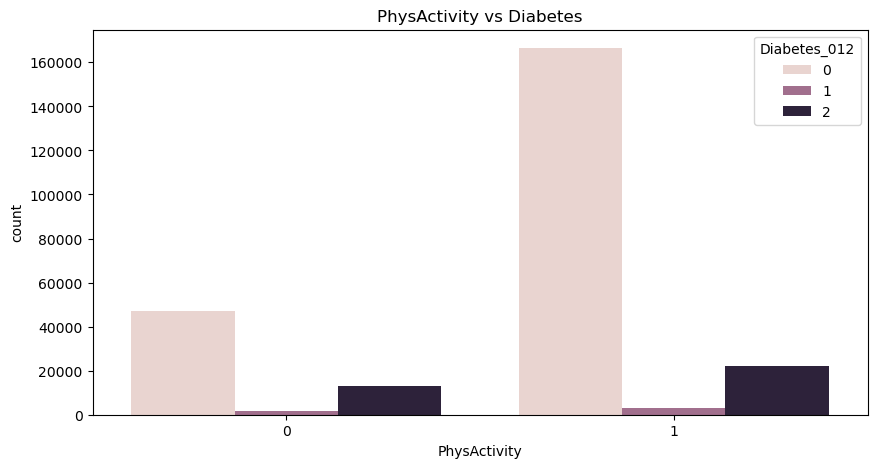

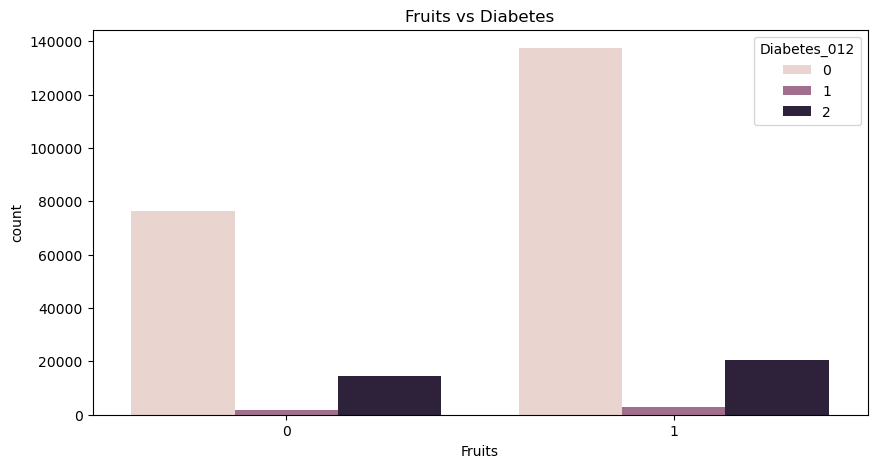

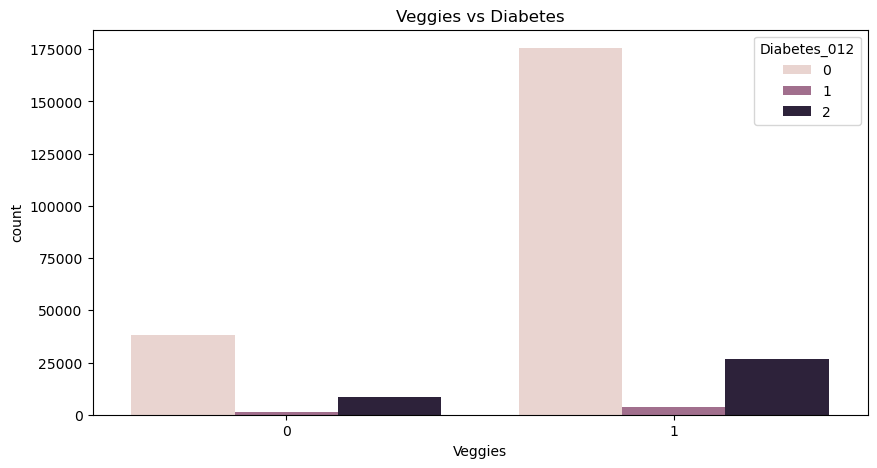

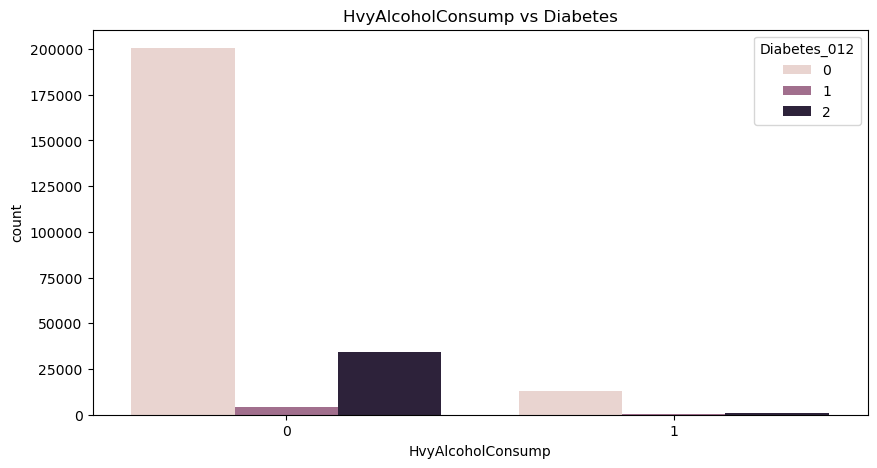

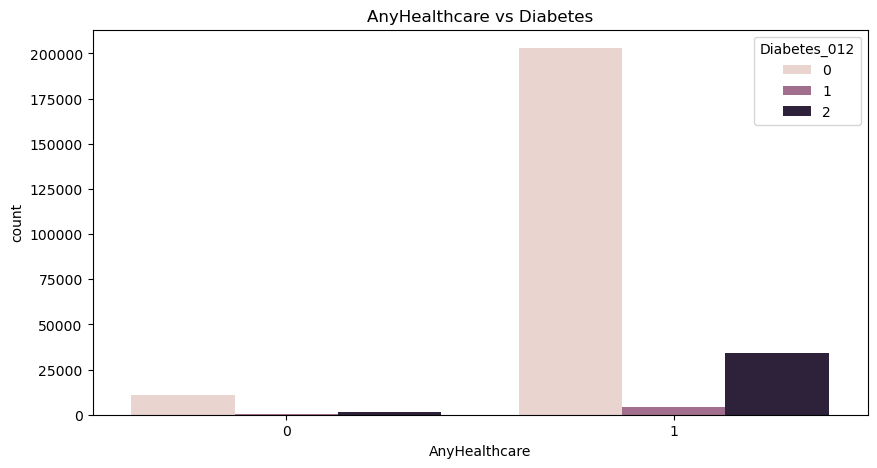

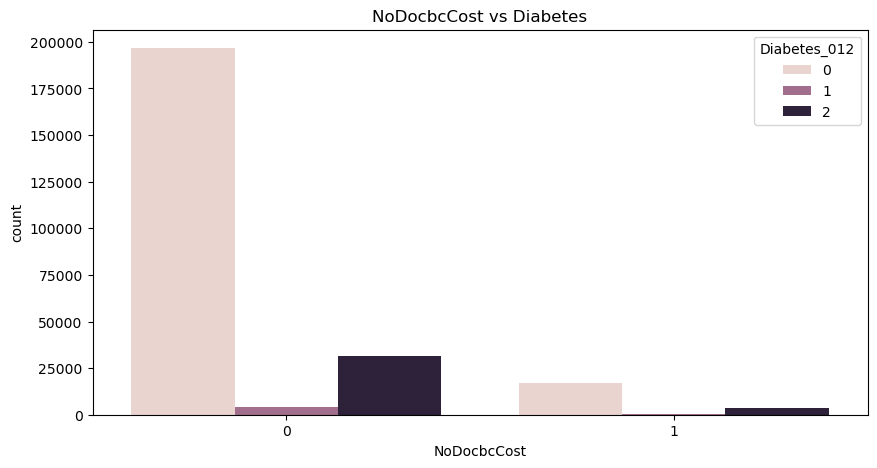

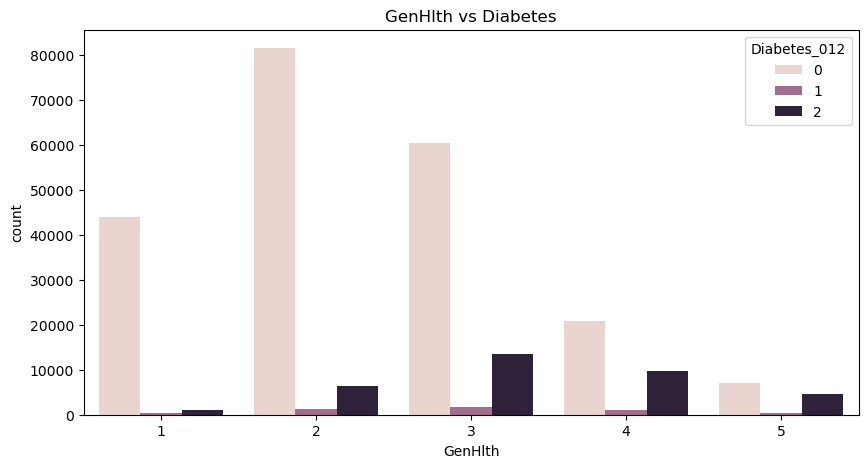

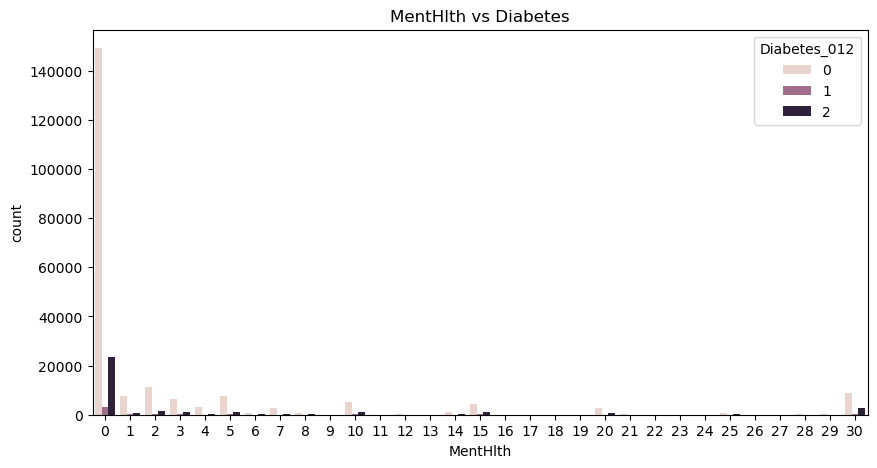

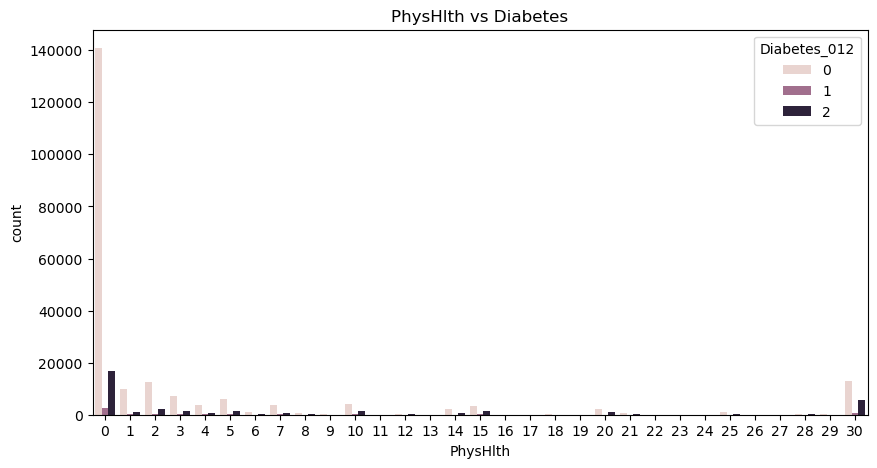

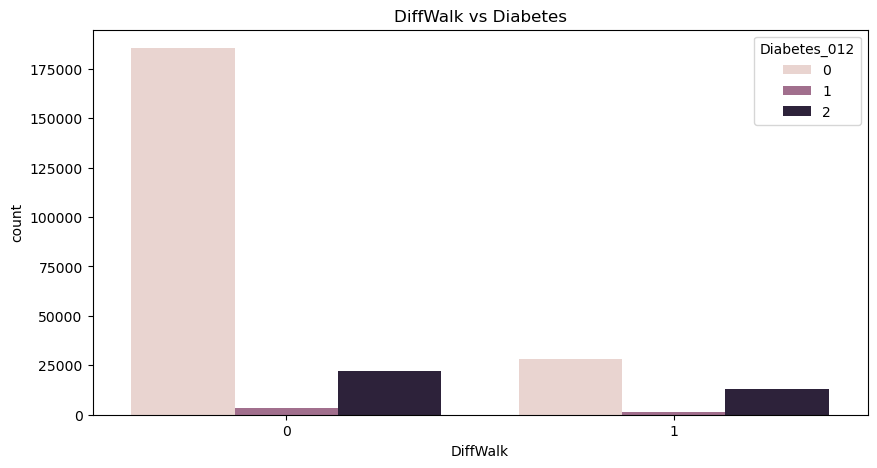

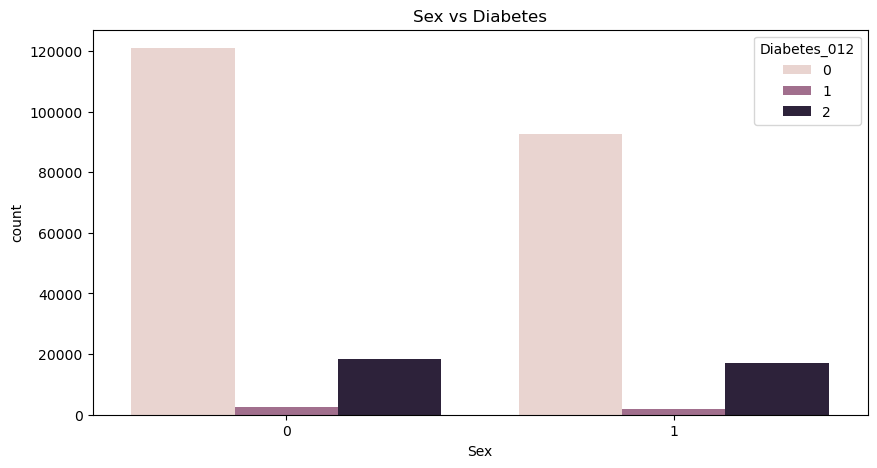

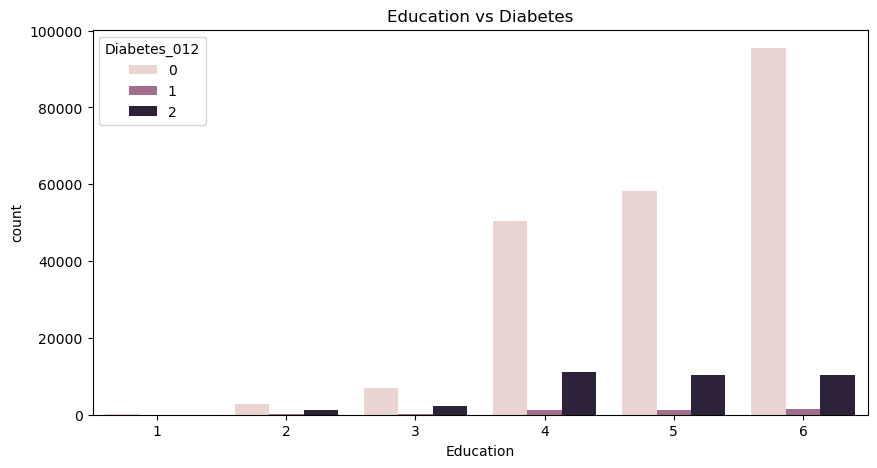

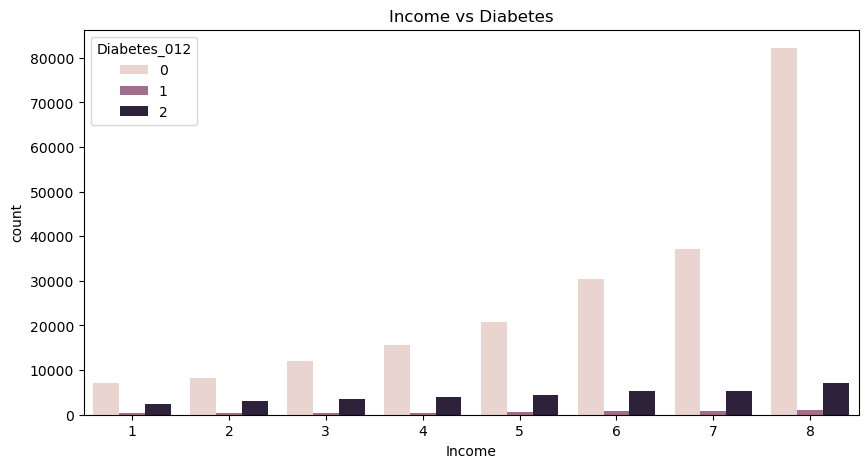

In [18]:
for col in cate_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, x=col, hue='Diabetes_012')
    plt.title(f'{col} vs Diabetes')
    plt.show()


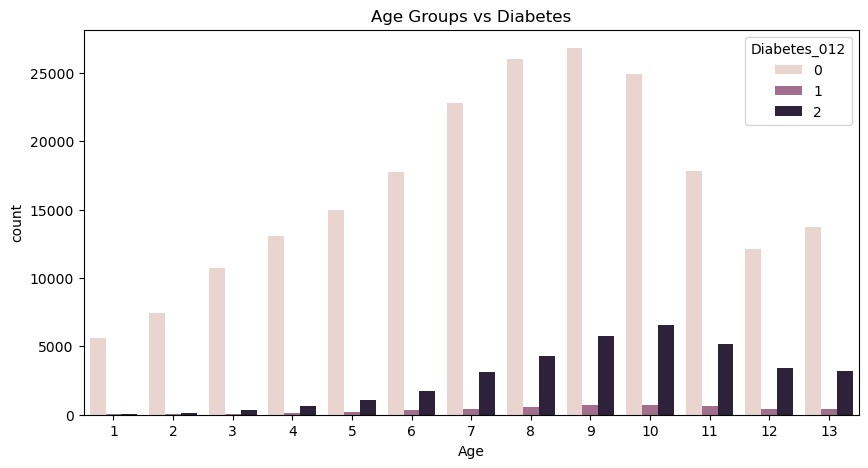

In [19]:
#for age as a categorical variable
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Age', hue='Diabetes_012')
plt.title('Age Groups vs Diabetes')
plt.show()

 

# Machine Learning Algorithms

## Logistic Regression

## Decision Tree

In [ ]:
# let's go

## Random Forest

Selected features: Index(['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack',
       'PhysActivity', 'Fruits', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Sex',
       'Age', 'Income'],
      dtype='object')


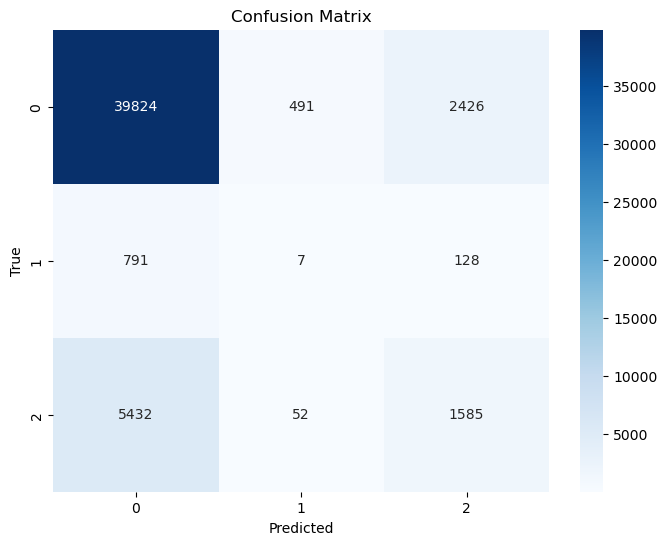

Random Forest Classifier
Accuracy: 0.8163040050457269
Precision: 0.7821585360671393
Recall: 0.8163040050457269
F1 Score: 0.7952794349939308
Log Loss: 0.8832573076719149
Cohen Kappa Score: 0.17946075069217593


In [37]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select the features
rdf_selector = SelectKBest(score_func=mutual_info_classif, k=13)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)

# RANDOM FOREST
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rdf, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
rdf.fit(X_train, y_train)

# Prediction
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))



## Lightgbm

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4639
[LightGBM] [Info] Number of data points in the train set: 341924, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4637
[LightGBM] [Info] Number of data points in the train set: 341924, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Inf

C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah

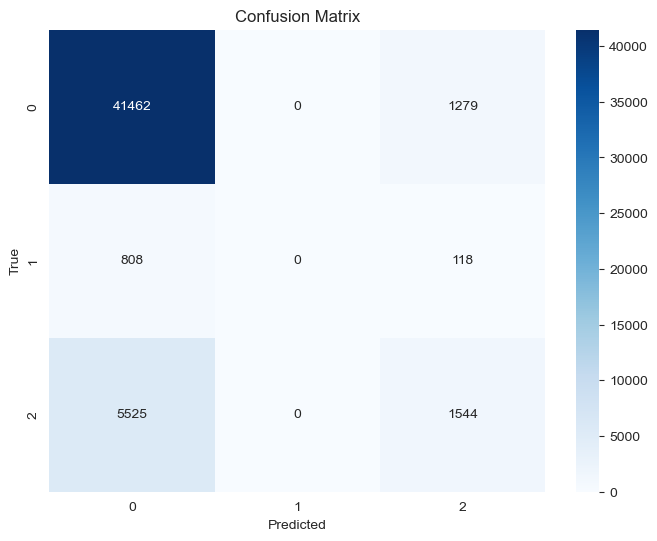

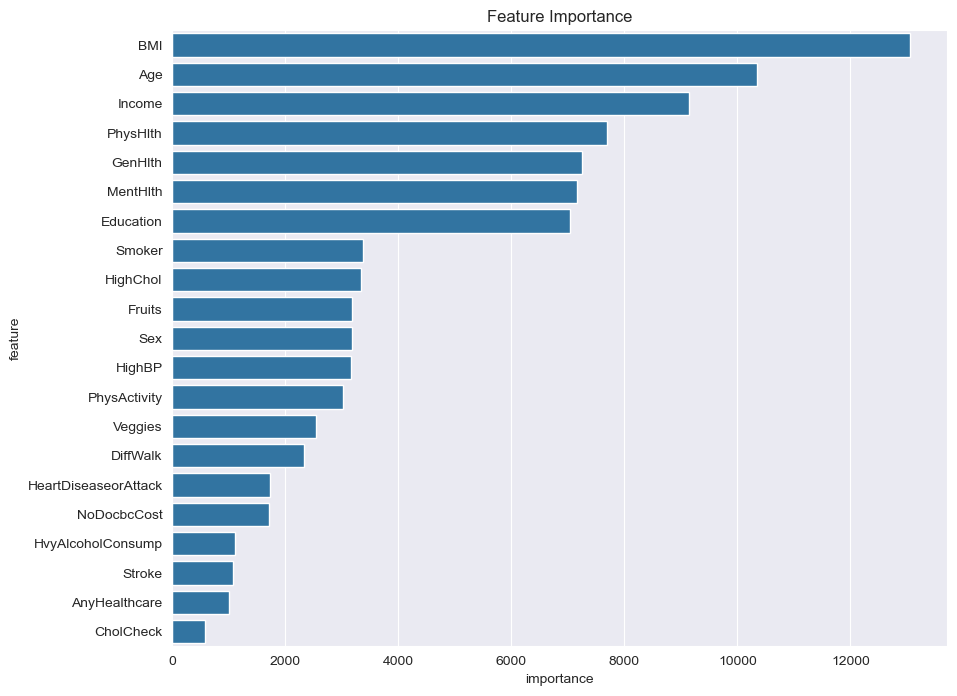

In [24]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================
#Feature selection LightGBM
# ===========================
"""
lgb_selector_model = lgb.LGBMClassifier(random_state=42)
lgb_selector_model.fit(X_scaled, y)
selector = SelectFromModel(lgb_selector_model, threshold="median", prefit=True)
X_selected = selector.transform(X_scaled)
selected_features = X.columns[selector.get_support()]
print("Selected features (LGBM):", list(selected_features))
"""
# ============================
# FEATURE SELECTION
#X_selected_df = pd.DataFrame(X_selected, columns=selected_features, index=data.index)
#X_model = X_selected_df  
X_model = pd.DataFrame(X_scaled, columns=X.columns)
# ============================
"""""
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_estimators=1000
)

# Train the model with early stopping and logging
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)  # log progress every 100 rounds
    ]
)"""
# ============================
# Search Parameters 
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42, stratify=y)

#==========================
#Oversamling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
#==========================

param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 1000],
    'min_child_samples': [10, 20, 50],
    'class_weight': ['balanced', None]
}

search = RandomizedSearchCV(
    lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='f1_macro',
    verbose=1
)

search.fit(X_train_bal, y_train_bal)
best_model = search.best_estimator_
# ============================
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_probs = best_model.predict_proba(X_test)

# Evaluation metrics
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
logloss = log_loss(y_test, y_pred_probs)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
importance = best_model.feature_importances_
feature_names = X_model.columns if isinstance(X_model, pd.DataFrame) else [f'feature_{i}' for i in range(X_model.shape[1])]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()



In [23]:
print(y.value_counts(normalize=True)) ##High imbalance --> Oversampling 

Diabetes_012
0    0.842412
2    0.139333
1    0.018255
Name: proportion, dtype: float64
